<a href="https://colab.research.google.com/github/ReidelVichot/LC_identification/blob/main/Infrastructure_092525.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

# -- Setting environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
dpath = '/content/drive/MyDrive/Disertation/'

# -- import county shapes
fname = 'countyshp/tl_2010_us_county00/tl_2010_us_county00.shp'
counties = gpd.read_file(dpath+fname)
counties["GEOID"] = counties['STATEFP00'].str.zfill(2) + counties['COUNTYFP00'].str.zfill(3)
cols = ['GEOID', 'geometry']
counties = counties[cols]

# -- set crs
crs = 'EPSG:4269'
counties = counties.to_crs(crs)

fname = '/content/drive/MyDrive/Disertation/stateshp/tl_2010_us_state10.shp'
states = gpd.read_file(fname)
states = states.to_crs(crs)
states = states[['GEOID10', 'geometry']].copy()

dpath = '/content/drive/MyDrive/Disertation/Infrastructure/'
# -- import highways
fname = 'BTS/Highways_DOT/Highways_DOT.shp'
highways = gpd.read_file(dpath+fname)
highways = highways.to_crs(crs)

# -- import Airports
fname = 'BTS/Airports_DOT/Airports_DOT.shp'
airports = gpd.read_file(dpath+fname)
airports = airports.to_crs(crs)

# -- import Ports
fname = 'BTS/Ports_DOT/Ports_DOT.shp'
ports = gpd.read_file(dpath+fname)
ports = ports.to_crs(crs)

# -- import rails
fname = 'BTS/Rail_DOT/Rail_DOT.shp'
rails = gpd.read_file(dpath+fname)
rails = rails.to_crs(crs)

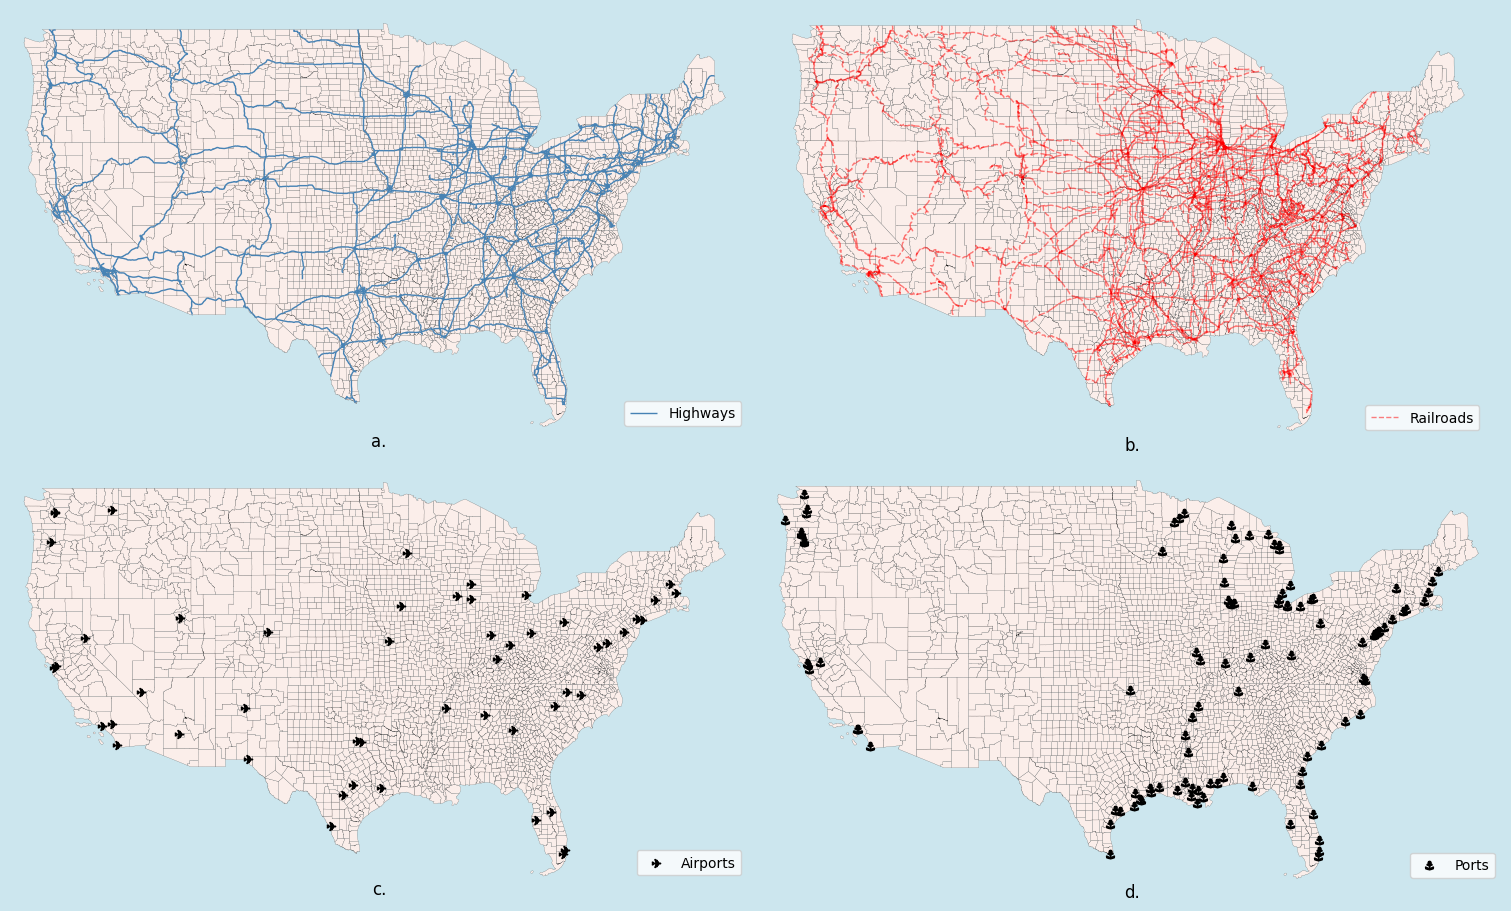

In [3]:
from matplotlib.markers import MarkerStyle
fig, ax = plt.subplots(2, 2, figsize=(15, 9), constrained_layout=True, facecolor='#CCE6EE')
x_lim = [-126, -65]
y_lim = [24, 50]
counties.plot(linewidth=0.1, edgecolor= "k", facecolor='#FBEEEA', ax=ax[0,0])
highways.plot(linewidth=1, color = 'steelblue',   ax=ax[0,0], label='Highways')
ax[0,0].set_facecolor('#CCE6EE')
counties.plot(linewidth=0.1, edgecolor= "k", facecolor='#FBEEEA', ax=ax[0,1])
rails.plot(linewidth=1, color = 'red', alpha=0.5, linestyle="--", ax=ax[0,1], label='Railroads')
ax[0,1].set_facecolor('#CCE6EE')
counties.plot(linewidth=0.1, edgecolor= "k", facecolor='#FBEEEA', ax=ax[1,0])
plane = MarkerStyle("$\u2708$")  # Unicode airplane character
airports.plot(marker=plane, c='k', ax=ax[1,0], label="Airports")
ax[1,0].set_facecolor('#CCE6EE')
counties.plot(linewidth=0.1, edgecolor= "k", facecolor='#FBEEEA', ax=ax[1,1])
anchor = MarkerStyle('$\u2693$') # Unicode anchor character
ports.plot(marker=anchor, c='k', ax=ax[1,1], label="Ports")
ax[1,1].set_facecolor('#CCE6EE')
# -- set legends
for row in range(2):
    for col in range(2):
        ax[row, col].legend(loc='lower right')
# -- set limits
for row in range(2):
    for col in range(2):
        ax[row, col].set_xlim(x_lim)
        ax[row, col].set_ylim(y_lim)
# -- remove axis from each subplot
for row in range(2):
    for col in range(2):
        ax[row, col].axis('off')
# -- add subtitles to each axis
ax[0, 0].set_title('a.', y=-0.05)
ax[0, 1].set_title('b.', y=-0.05)
ax[1, 0].set_title('c.', y=-0.05)
ax[1, 1].set_title('d.', y=-0.05)
fig.show()

Caption: a. Highways in the United States; b. Freight Rails in the Unites States; c. Freight Airports in the United States; d. Freight Ports in the United States. All data retrieved from the Bureau of Transportation Statistics' Interim National Multimodal Freight Network, and accessed in 2024.

In [7]:
# -- Removing non continental counties
nc_states = ['02', '15', '60', '66', '69', '72', '78']
for i in nc_states:
  counties = counties[~counties['GEOID'].str.startswith(i)]

highway_county = gpd.overlay(highways[["geometry"]], counties, how='intersection')

In [15]:
counties.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [42]:
# Create a temporary column to store distances
counties_test = counties.copy()
counties_test["distance"] = 0.0
counties_test.head()

counties_projected = counties_test.to_crs(epsg=3857)
highways_projected = highways.to_crs(epsg=3857)
counties_projected["geometry"] = counties_projected.centroid
a = gpd.sjoin_nearest(counties_projected, highways_projected[["geometry"]], how="left",  distance_col="distance")

In [44]:
a[a["GEOID"]=="10003"]

,GEOID,geometry,distance,index_right
1579,10003,POINT (-8420088.059 4804926.444),13086.916667,507


In [49]:
counties[counties['GEOID']=="10003"].centroid

/tmp/ipython-input-463588492.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  counties[counties['GEOID']=="10003"].centroid


,0
1579,POINT (-75.63898 39.57833)


In [47]:
highways_projected.iloc[507]

,507
stfips,10
ctfips,3
disolveval,I95
miles,27.42202
kilometers,44.131551
geometry,MULTILINESTRING ((-8436656.187399998 4813586.1...


In [36]:
counties_projected["geometry"] = counties_projected.centroid


,GEOID,geometry,distance
2,28101,POINT (-9920660.38 3815985.517),0.0
3,28027,POINT (-10085841.352 4059651.59),0.0
4,22065,POINT (-10157079.801 3811259.3),0.0
5,51003,POINT (-8744870.641 4582707.04),0.0
6,51540,POINT (-8736975.382 4584714.015),0.0


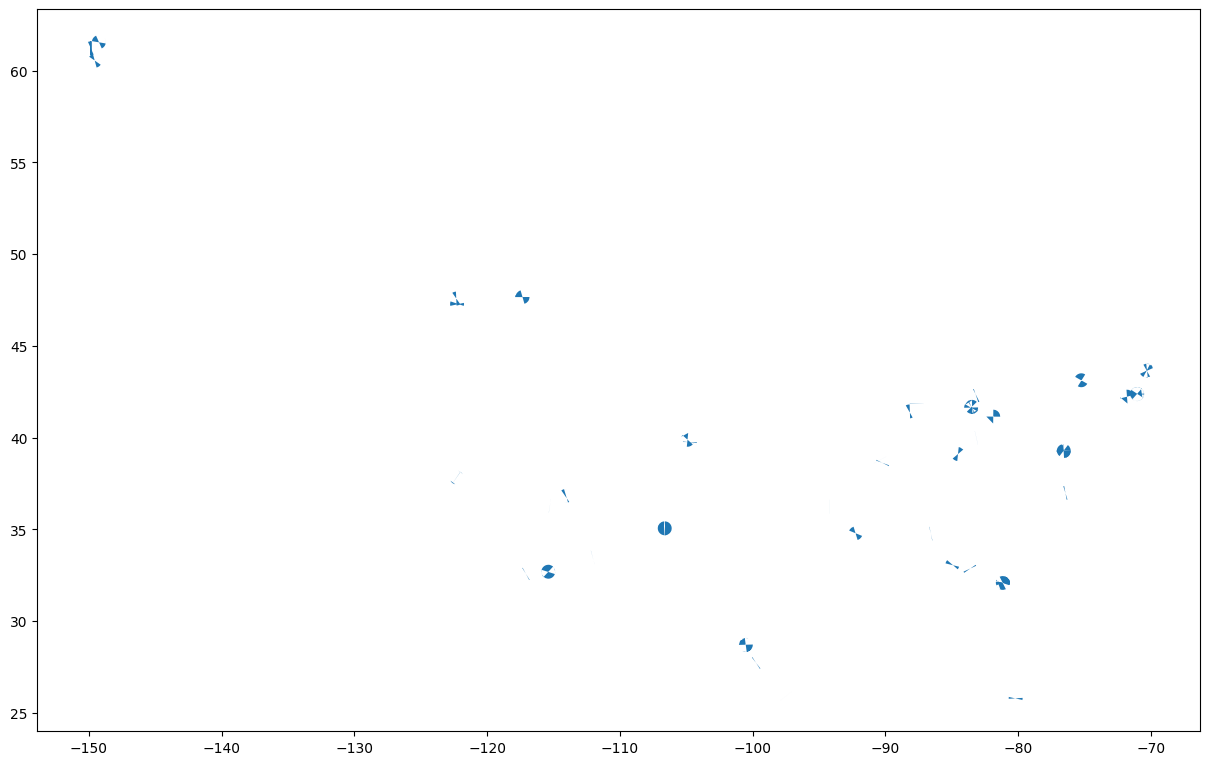

In [26]:
fig, ax = plt.subplots(figsize=(15, 15))
highways.head().plot(linewidth=10, ax=ax)
#counties.head().plot(ax=ax, edgecolor= "r")
fig.show()

<Axes: >

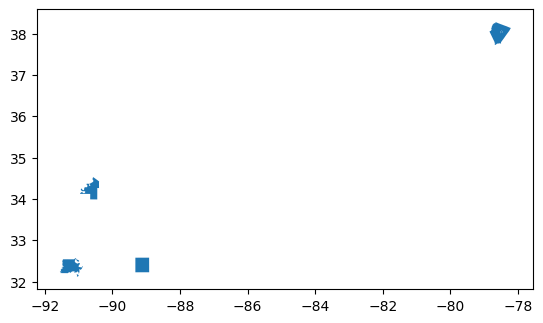

In [18]:
counties.head().plot()

In [3]:
counties_test = counties.copy()

NameError: name 'counties' is not defined

In [28]:
# Create a temporary column to store distances
counties_test = counties.copy()
counties_test["distance"] = 0.0

# Perform the spatial join to find the nearest line and its distance
# Ensure 'geometry' column is present in the lines GeoDataFrame
joint = gpd.sjoin_nearest(counties_test.centroid,
    highways[['geometry']],
    how="left",
    distance_col="distance"
)

ValueError: Unknown column geometry

In [20]:
counties.centroid.crs

/tmp/ipython-input-2908535983.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  counties.centroid.crs


<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [4]:
highway_county = gpd.overlay(highways[["geometry"]], counties, how='intersection')


In [4]:
# -- Fast Act Urban and Rural Freight Corridors
fname = 'FAST Act/Critical Freight Corridors 112424 v2.shp'
CFC = gpd.read_file(dpath+fname)
CFC = CFC.to_crs(crs)
# -- Fast Act National Highway Freight Network
fname = 'FAST Act/National Highway Freight Network 112424 v2.shp'
NHFN = gpd.read_file(dpath+fname)
NHFN = NHFN.to_crs(crs)

/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:198: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D LineString' is converted to 'LineString Z'
  return ogr_read(
/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:198: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured LineString' is converted to 'LineString'
  return ogr_read(


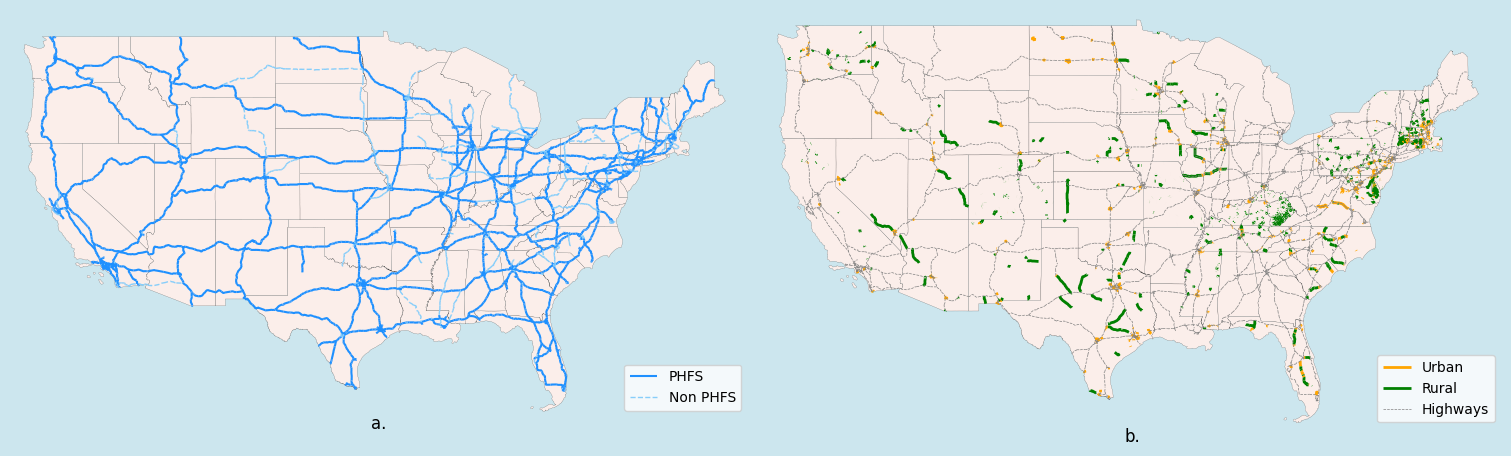

In [5]:
from matplotlib.markers import MarkerStyle
fig, ax = plt.subplots(1, 2, figsize=(15, 5), constrained_layout=True, facecolor='#CCE6EE')
x_lim = [-126, -65]
y_lim = [24, 50]

states.plot(linewidth=0.1, edgecolor= "k", facecolor='#FBEEEA', ax=ax[0])
NHFN[NHFN['NHFN']==   'PHFS'].plot(linewidth=1.5, color = 'dodgerblue', ax=ax[0], label='PHFS')
NHFN[NHFN['NHFN']=='NonPHFS'].plot(linewidth=1, color = 'lightskyblue', linestyle='--', ax=ax[0], label='Non PHFS')


ax[0].set_facecolor('#CCE6EE')

states.plot(linewidth=0.1, edgecolor= "k", facecolor='#FBEEEA', ax=ax[1])
CFC[CFC['NHFN_PART']=='Urban'].plot(linewidth=2, color = 'orange', alpha=1, ax=ax[1], label='Urban')
CFC[CFC['NHFN_PART']=='Rural'].plot(linewidth=2, color = 'green', alpha=1, ax=ax[1], label='Rural')
highways.plot(linewidth=0.5, color = 'gray', linestyle='--', ax=ax[1], label='Highways')
ax[1].set_facecolor('#CCE6EE')

# -- set legends
for col in range(2):
  ax[col].legend(loc='lower right')
# -- set limits
for col in range(2):
  ax[col].set_xlim(x_lim)
  ax[col].set_ylim(y_lim)
# -- remove axis from each subplot
for col in range(2):
  ax[col].axis('off')
# -- add subtitles to each axis
ax[0].set_title('a.', y=-0.05)
ax[1].set_title('b.', y=-0.05)

fig.show()

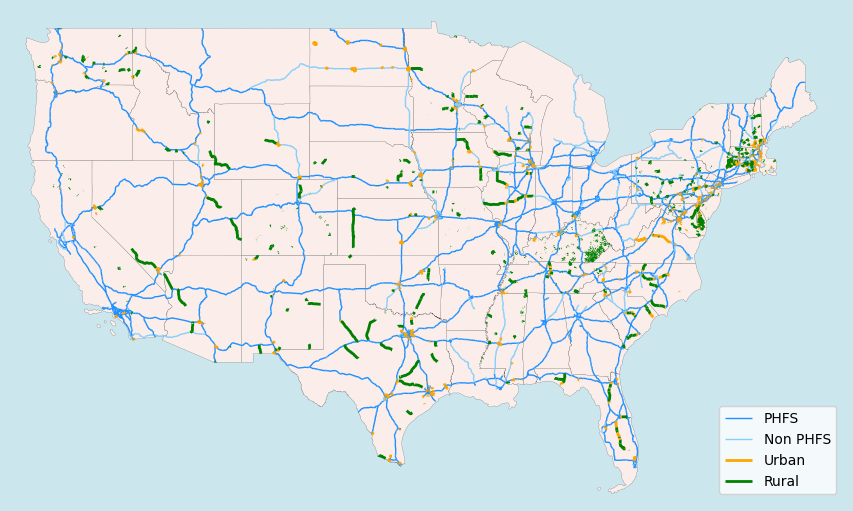

In [6]:
from matplotlib.markers import MarkerStyle
fig, ax = plt.subplots(1, 1, figsize=(15, 5), constrained_layout=True, facecolor='#CCE6EE')
x_lim = [-126, -65]
y_lim = [24, 50]

states.plot(linewidth=0.1, edgecolor= "k", facecolor='#FBEEEA', ax=ax)
NHFN[NHFN['NHFN']==   'PHFS'].plot(linewidth=1, color = 'dodgerblue', ax=ax, label='PHFS')
NHFN[NHFN['NHFN']=='NonPHFS'].plot(linewidth=1, color = 'lightskyblue', ax=ax, label='Non PHFS')
CFC[CFC['NHFN_PART']=='Urban'].plot(linewidth=2, color = 'orange', alpha=1, ax=ax, label='Urban')
CFC[CFC['NHFN_PART']=='Rural'].plot(linewidth=2, color = 'green', alpha=1, ax=ax, label='Rural')

ax.set_facecolor('#CCE6EE')

ax.legend(loc='lower right')
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
ax.axis('off')

fig.show()

Question 16: Can a non-PHFS Interstate System route be designated as a CRFC or CUFC? (Added May 23, 2016)

Answer 16: Yes, the law does not prohibit the designation of a non-PHFS Interstate System route as a CRFC or CUFC. For a CRFC, the designated public road cannot be in an urbanized area and must meet one or more of the elements listed in 23 U.S.C. 167(e)(1). For a CUFC, the designated public road must be in an urbanized area and meet one or more of the elements listed in 23 U.S.C. 167(f)(3). Note that the designation of a non-PHFS Interstate System route as a CRFC or CUFC will count against the cap on mileage designation, which is established on a Statewide basis (23 U.S.C. 167(e)(2) and (f)(4)).

In [7]:
# -- intermodal facilies
fname = 'NTAD_Intermodal_Freight_Facilities_Air_to_Truck/Intermodal_Freight_Facilities_Air-to-Truck.shp'
air_truck = gpd.read_file(dpath+fname)
air_truck = air_truck.to_crs(crs)
cols =['FACILITY_C', 'geometry']
air_truck = air_truck[cols]

fname = 'NTAD_Intermodal_Freight_Facilities_Rail_TOFC_COFC/Intermodal_Freight_Facilities_Rail_TOFC_COFC.shp'
rail_tofc = gpd.read_file(dpath+fname)
rail_tofc = rail_tofc.to_crs(crs)
cols = ['EQUIPMENT', 'geometry']
rail_tofc = rail_tofc[cols]



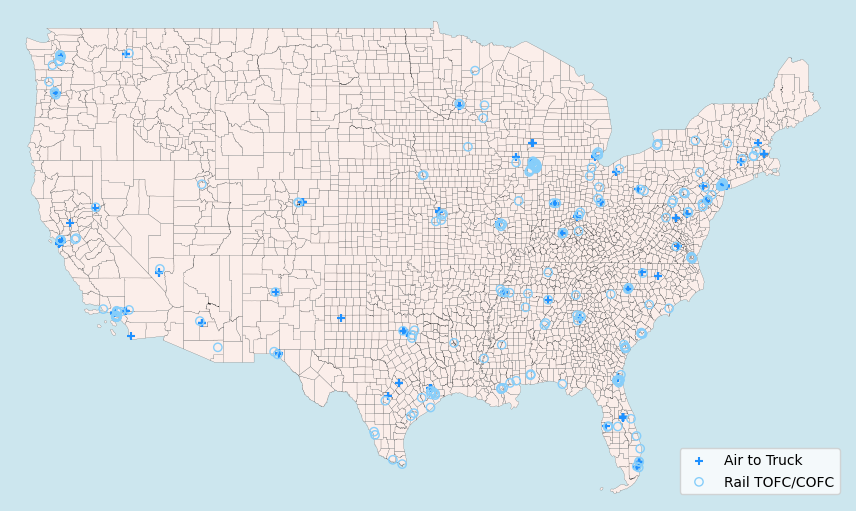

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5), constrained_layout=True, facecolor='#CCE6EE')

counties.plot(linewidth=0.1, edgecolor= "k", facecolor='#FBEEEA', ax=ax)
air_truck.plot(marker='+', color = 'dodgerblue', ax=ax, label='Air to Truck')
rail_tofc.plot(marker='o', facecolor='none', edgecolor='lightskyblue', ax=ax, label='Rail TOFC/COFC')

ax.set_facecolor('#CCE6EE')
ax.legend(loc='lower right')
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
ax.axis('off')

plt.show()

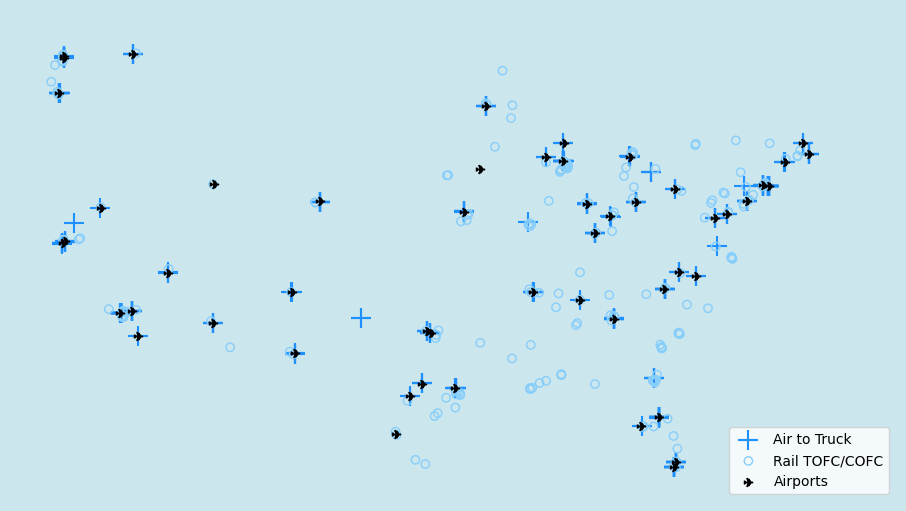

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5), constrained_layout=True, facecolor='#CCE6EE')

#counties.plot(linewidth=0.1, edgecolor= "k", facecolor='#FBEEEA', ax=ax)
air_truck.plot(marker='+',markersize=200, color = 'dodgerblue', ax=ax, label='Air to Truck')
rail_tofc.plot(marker='o', facecolor='none', edgecolor='lightskyblue', ax=ax, label='Rail TOFC/COFC')
airports.plot(marker=plane, c='k', ax=ax, label="Airports")

ax.set_facecolor('#CCE6EE')
ax.legend(loc='lower right')
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
ax.axis('off')

plt.show()